In [22]:
import matplotlib.pyplot as plt
from skimage import io, filters, util, restoration
import os
import numpy as np

In [23]:
DATA_DIR = r'D:\Researchdata\031722'

In [24]:
for parent, dir, file in os.walk(DATA_DIR):
    if( 'tiff' in parent):
        for f in file:
            raw_stack = io.imread(os.path.join(parent, f))
            break


In [25]:
img = raw_stack[4, ...,2]
# io.imshow(img, cmap = 'gray')

In [26]:
background = restoration.rolling_ball(img, radius = 200)
reduce_bg_img = img - background
# io.imshow(reduce_bg_img, cmap = 'gray')

In [20]:
thresh = filters.threshold_otsu(reduce_bg_img)
binary = reduce_bg_img > thresh
# io.imshow(np.int0(binary), cmap = 'gray')

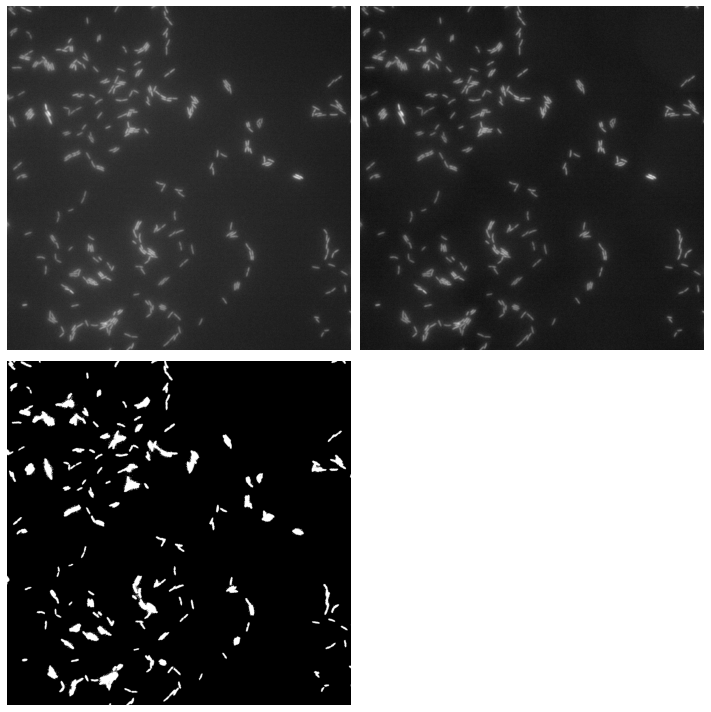

In [27]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

ax[0, 0].imshow(img, cmap = 'gray')
ax[0, 1].imshow(reduce_bg_img, cmap = 'gray')
ax[1, 0].imshow(np.int0(binary), cmap = 'gray')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()